In [1]:
%%capture
%pip install ortools
%pip install tdqm

In [2]:
from ortools.linear_solver import pywraplp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

In [3]:
areaDataframe = pd.read_csv('areaData.csv')

In [4]:
areaDataframe.head()

,section,width,length,area
0,1,1.57,10.18,15.9826
1,2,2.14,7.64,16.3496
2,3,1.57,10.18,15.9826
3,4,1.57,14.56,22.8592
4,5,2.14,12.14,25.9796


In [5]:
maxArea = areaDataframe['area'].values #in m^2
maxArea

array([15.9826, 16.3496, 15.9826, 22.8592, 25.9796, 25.4026, 18.9342,
       23.219 , 18.9342, 13.9573, 16.3496, 13.9573, 15.6434, 33.8954,
       15.6434, 20.7152, 37.2788, 20.7152,  9.5123, 19.0246,  9.5123,
        4.7508,  9.5016,  4.7508])

In [6]:
# Create a solver
solver = pywraplp.Solver.CreateSolver('GLOP')

# Define decision variables
n_classes = 4
n_sections = maxArea.size
seats = {}
cost = [864, 2054,5763,12184] #economic, premium, business, first
weight = [64,64,64,64] #economic, premium, business, first (in Kg)
max_weight = 395000 #in Kg
demand = [1200, 250,50,26] #economic, premium, business, first
sizes = [0.39,0.478,1.06,1.829] #economic, premium, business, first (in m^2)

for i in range(n_classes):
    for j in range(n_sections):
        seats[i, j] = solver.IntVar(0, solver.infinity(), f'seats_{i}_{j}')

# Define objective function
revenue = solver.Sum(seats[i, j] * cost[i] for i in range(n_classes) for j in range(n_sections))

# Maximize revenue
solver.Maximize(revenue)

# Area constraint
for j in range(n_sections):
    solver.Add(
        solver.Sum(seats[i, j] * sizes[i] for i in range(n_classes)) <= maxArea[j]
    )

# Weight constraint
weight_constraint = solver.Sum(
    seats[i, j] * weight[i] 
    for i in range(n_classes) 
    for j in range(n_sections)
) <= max_weight

# Demand constraint
for i in range(n_classes):
    solver.Add(
        (solver.Sum(seats[i, j] for j in range(n_sections)) <= demand[i])
    )


In [7]:
# Solve the problem
status = solver.Solve()

# Get the optimal solution

if status == pywraplp.Solver.OPTIMAL:
    print('Objective value Revenue =', solver.Objective().Value())
else:
    print('The problem does not have an optimal solution.')

Objective value Revenue = 1581000.9907692308


In [8]:
def plot_seats():


SyntaxError: unexpected EOF while parsing (102367587.py, line 1)

473.0
250.0
50.0
24.0


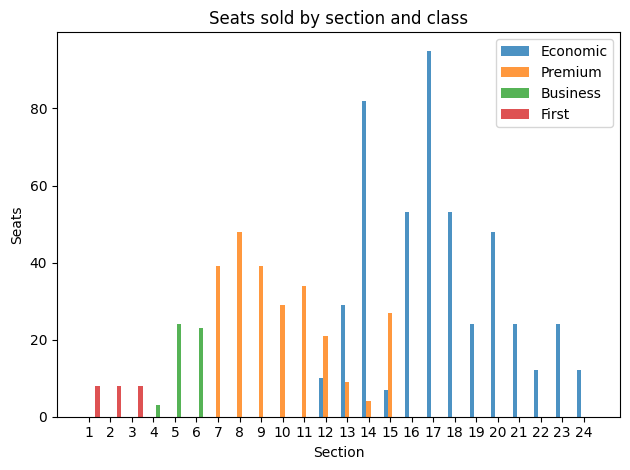

In [ ]:
# Create a histogram of each section and show the distribution of seats sold in each class
fig, ax = plt.subplots()
index = np.arange(n_sections)
bar_width = 0.2
opacity = 0.8
class_labels = ['Economic', 'Premium', 'Business', 'First']

for i in range(n_classes):
    values = [seats[i, j].solution_value() for j in range(n_sections)]
    print(np.sum(values))
    ax.bar(index + i * bar_width, values, bar_width, alpha=opacity, label=class_labels[i])

ax.set_xlabel('Section')
ax.set_ylabel('Seats')
ax.set_title('Seats sold by section and class')
ax.legend()

ax.set_xticks(index + bar_width)
ax.set_xticklabels(index)

#move the x axis +1 so counts start from 1
fig.canvas.draw()
labels = [item.get_text() for item in ax.get_xticklabels()]
labels = [int(float(label)) + 1 for label in labels]
ax.set_xticklabels(labels)

fig.tight_layout()
plt.show()

## Modelling for Location Based Seat Optimization (Regularization/Penalties)
This time, we try to minmize the costs of assigning a seat with a specific economy class $i$ to section $j$ to try to partition the classes by plane sections.

As we can see above, even though our solution is mathematically "correct" in that it finds the seating assignment with the largest possible revenue given the constraints, it has room for improvement when considering the human decision making process. After all, we are assuming there are four different cabin classes with different price points, so we do want to make the higher classes as appealing to the customer as possible.

Following the current norm for airplane seating arrangements, our goal for this improved problem formulation is to try to incentivise the algorithm to place first/business at the front of the plane and economy at the back of the plane. Adding constraints to where seats can be placed won't solve the problem since we will end up doing a simple division to see how many seats of a certain class can fit into a designated area.

One idea is to **penalize** poor seat assignment by subtracting from the total revenue some cost for assigning a seat too far away.



### Objective Function
L

### Variables
Let $c_{ij}$ be the cost of assigning seat class $i$ to section $j$

$$
c_{0,j} = \begin{cases}
0 \\
1 \\
2 \\
3 \\
\end{cases}
$$

### Equally Distribute Seats and Penalize Based on Relative Index Distance

In [ ]:
# C = np.array([
#     [3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0], # Econ
#     [2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1], # Prem. Econ
#     [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2], # Business
#     [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3]  # First
# ])

# C = np.array([
#     [40, 40, 40, 40, 40, 40, 20, 20, 20, 20, 20, 20, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0], # Econ
#     [30, 30, 30, 30, 30, 30, 15, 15, 15, 15, 15, 15, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 10, 10, 10], # Prem. Econ
#     [20, 20, 20, 20, 20, 20, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 10, 10, 30, 30, 30, 30, 30, 30, 30], # Business
#     [0, 0, 0, 0, 0, 0, 5, 5, 5, 5, 5, 5, 10, 10, 10, 10, 10, 10, 20, 20, 20, 20, 20, 20, 20]  # First
# ])

C = np.array([
    [100, 100, 100, 100, 100, 100, 100, 100, 100, 50, 50, 50, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # Econ
    [100, 100, 100, 100, 100, 100, 0, 0, 0, 0, 0, 0, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50], # Prem. Econ
    [100, 100, 100, 0, 0, 0, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50], # Business
    [0, 0, 0, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]  # First
])

cost_penalty_function = lambda x: x**2
# cost_penalty_function = lambda x: x
cost_penalty_function_transform = np.vectorize(cost_penalty_function)
cost_penalty = cost_penalty_function(C)

In [ ]:
cost_penalty

array([[10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000,
           25,    25,    25,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0],
       [10000, 10000, 10000, 10000, 10000, 10000,     0,     0,     0,
            0,     0,     0,    25,    25,    25,  2500,  2500,  2500,
         2500,  2500,  2500,  2500,  2500,  2500,  2500],
       [10000, 10000, 10000,     0,     0,     0,    25,    25,    25,
           25,    25,    25,  2500,  2500,  2500,  2500,  2500,  2500,
         2500,  2500,  2500,  2500,  2500,  2500,  2500],
       [    0,     0,     0,    25,    25,    25,  2500,  2500,  2500,
         2500,  2500,  2500,  2500,  2500,  2500,  2500,  2500,  2500,
         2500,  2500,  2500,  2500,  2500,  2500,  2500]])

In [ ]:
# Create a solver
solver = pywraplp.Solver.CreateSolver('SAT')

# Define decision variables
n_classes = 4
n_sections = maxArea.size
seats = {}
cost = [864, 2054,5763,12184] #economic, premium, business, first
weight = [64,64,64,64] #economic, premium, business, first (in Kg)
max_weight = 395000 #in Kg
demand = [np.infty, 250,50,24] #economic, premium, business, first
sizes = [0.39,0.478,1.06,1.829] #economic, premium, business, first (in m^2)

for i in range(n_classes):
    for j in range(n_sections):
        seats[i, j] = solver.IntVar(0, solver.infinity(), f'seats_{i}_{j}')

# Define objective function
cost = solver.Sum(((seats[i,j] * cost[i]) - (seats[i, j] * cost_penalty[i,j])) for i in range(n_classes) for j in range(n_sections))

# Maximize revenue
solver.Maximize(cost)

# Area constraint
for j in range(n_sections):
    solver.Add(
        solver.Sum(seats[i, j] * sizes[i] for i in range(n_classes)) <= maxArea[j]
    )

# Weight constraint
weight_constraint = solver.Sum(
    seats[i, j] * weight[i] 
    for i in range(n_classes) 
    for j in range(n_sections)
) <= max_weight

# Demand constraint
for i in range(n_classes):
    solver.Add(
        (solver.Sum(seats[i, j] for j in range(n_sections)) <= demand[i])
    )


NameError: name 'cost_penalty' is not defined

In [ ]:
# Solve the problem
status = solver.Solve()

# Get the optimal solution

if status == pywraplp.Solver.OPTIMAL:
    print('Objective value Revenue =', solver.Objective().Value())
else:
    print('The problem does not have an optimal solution.')

Objective value Revenue = 0.0


0.0
0.0
0.0


0.0


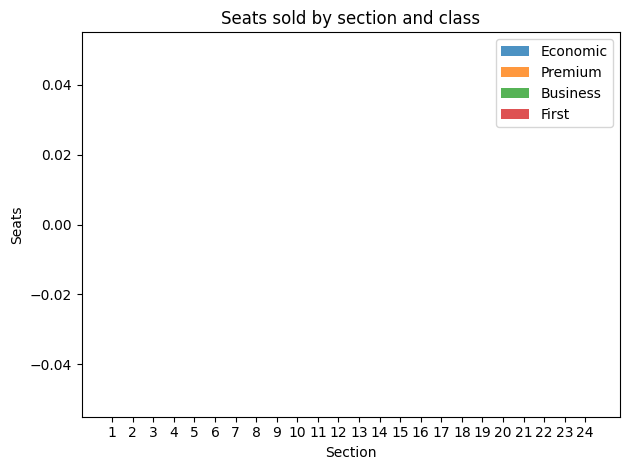

In [ ]:
# Create a histogram of each section and show the distribution of seats sold in each class
fig, ax = plt.subplots()
index = np.arange(n_sections)
bar_width = 0.2
opacity = 0.8
class_labels = ['Economic', 'Premium', 'Business', 'First']

for i in range(n_classes):
    values = [seats[i, j].solution_value() for j in range(n_sections)]
    print(np.sum(values))
    ax.bar(index + i * bar_width, values, bar_width, alpha=opacity, label=class_labels[i])

ax.set_xlabel('Section')
ax.set_ylabel('Seats')
ax.set_title('Seats sold by section and class')
ax.legend()

ax.set_xticks(index + bar_width)
ax.set_xticklabels(index)

#move the x axis +1 so counts start from 1
fig.canvas.draw()
labels = [item.get_text() for item in ax.get_xticklabels()]
labels = [int(float(label)) + 1 for label in labels]
ax.set_xticklabels(labels)

fig.tight_layout()
plt.show()

## Penalize Based on Priority Seating

We design costs based on the following assumptions:

- First class should be primarily placed in sections 1,2,3 and secondarily in 4,5,6.
- Business class should be primarily placed in sections 4,5,6.
- Premium economy should be primarily placed in 7,8,9,10,11,12 and could star
- Economy should be primarily placed in 13-24

We also want to incur large penalties by trying to move up section numbers.

In [ ]:
C = np.array([
    [100, 100, 100, 100, 100, 100, 100, 100, 100, 50, 50, 50, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # Econ
    [100, 100, 100, 100, 100, 100, 0, 0, 0, 0, 0, 0, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50], # Prem. Econ
    [100, 100, 100, 0, 0, 0, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50], # Business
    [0, 0, 0, 5, 5, 5, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]  # First
])

## Simulations

We will simulate a group of passengers buying airplane tickets using the Zipf distribution to sample

In [ ]:
from enum import Enum

class TravelClass(Enum):
    ECONOMY = "1"
    PREMIUM_ECONOMY = "2"
    BUSINESS = "3"
    FIRST = "4"
    
prices = [864, 2054,5763,12184] #economic, premium, business, first

def simulate_buying_tickets():
    """
    Sample from the Zipf distribution num_samples times. Returns an array of tickets bought for each flight class

    Returns:
    An array of tjkickets bought for each flight class
    """
    # Total number of people buying tickets
    demand = np.random.lognormal(mean=np.log(1000), sigma=0.2)

    # Sample from Zipf distribution the number of tickets per class
    samples = np.random.zipf(3, size=int(demand))

    # Clip samples to be within range [1, 4]
    samples = np.clip(samples, 1, 4)

    # Convert samples to integers
    samples = samples.astype(int)


    return np.histogram(samples, bins=np.arange(1, 6))[0]

def simulate_revenue(num_econ, num_prem_econ, num_business, num_first, num_iters=1000):
    """
    Simulate the ticket buying process for a given set of seats. Returns the average revenue.

    Params:
    - num_econ: total allowed number of economy class tickets in layout
    - num_prem_econ: total allowed number of economy class tickets in layout
    - num_business: total allowed number of business class tickets in layout
    - num_first: total allowed number of first class tickets in layout
    - num_iters: number of trials to run simulating ticket buying

    Returns:
    Average revenue 

    """
    total_revenues = []
    for _ in range(num_iters):
        ticket_counts = np.array(simulate_buying_tickets())

        ticket_counts[0] = max(ticket_counts[0], num_econ)
        ticket_counts[1] = max(ticket_counts[1], num_prem_econ)
        ticket_counts[2] = max(ticket_counts[2], num_business)
        ticket_counts[3] = max(ticket_counts[3], num_first)

        ticket_prices = np.array(prices)

        revenue = np.dot(ticket_counts, ticket_prices)
        total_revenues.append(revenue)

    return np.average(total_revenues)

In [ ]:
simulate_revenue(473, 250, 50, 24)

1953146.012

473.0
250.0
50.0
24.0

## Avg Revenue Results